## Jupyter Kernel for Rust Programming Language

[evcxr] is an evaluation context for Rust. It is an unofficial google project that offers several related crates, one of which is [evcxr_jupyter] which is a Juypter Kernel for the Rust programming language.

BTW, if you're wondering how to pronounce `EvCxR`; it's pronounced *"Evic-ser"* cos it's an **EV**aluation Conte**X**t for **R**ust.

You can take a [tour of the Juypter Kernel][tour] to get a feel for using Rust in Jupyter Notebooks.

## Setup

You can setup `evcxr_jupyter` by running the following commands:

```sh
cargo install evcxr_jupyter
evcxr_jupyter --install
```

Check full installation instructions [here][install].

### Plotly Jupyter Support

To show plots in Jupyter notebook, install the jupyterlab extension by executing the following command:

```sh
jupyter labextension install jupyterlab-plotly
```

Visit the [Jupyter Support] for plotly guide for more installation help.

[evcxr]: https://github.com/google/evcxr
[evcxr_jupyter]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/README.md
[install]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/README.md#installation
[tour]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/samples/evcxr_jupyter_tour.ipynb
[Jupyter Support]: https://igiagkiozis.github.io/plotly/content/fundamentals/jupyter_support.html

# Iris Dataset

## Install and add dependencies

In [2]:
// Install dependecies: eq. of add it to "Cargo.toml".
:dep eyre
// for multi-dimensional array.
:dep ndarray
// for machine learning
:dep linfa
:dep linfa-trees
// for downloading data
:dep reqwest = { version = "0.11.13", features = ["blocking"] }
// for working with dataframe
:dep polars = { version = "0.26.1", features = ["ndarray", "lazy", "describe", "dtype-full"] }
// for plotting data.
:dep plotly = { version = "0.6", features=["plotly_ndarray"] }

In [3]:
use std::{
  fs::{self, File},
  io::{Cursor, Write},
  path::Path,
};

use eyre::Result;
use reqwest::blocking::Client;

use linfa::prelude::*;
use linfa_trees::{DecisionTree, SplitQuality};

use ndarray::prelude::*;
use polars::prelude::*;

use plotly::{common::Mode, Scatter, Plot};

## Load data into `DataFrame` or `LazyFrame`

In [4]:
/// Save dataframe to disk.
pub fn save_df(df: &mut DataFrame, path: &Path) -> Result<()> {
  if !path.exists() {
    // See if parent folder exists.
    let parent = path.parent().unwrap();
    if !parent.is_dir() {
      std::fs::create_dir_all(&parent).unwrap();
    }
    // Create file.
    let mut file = File::create(&path)?;

    // Save dataframe.
    CsvWriter::new(&mut file).finish(df)?;
    println!("File saved to:  {}", path.display());
  } else {
    println!("File already exists.");
  }

  Ok(())
}

/// Load Iris dataset into a dataframe from file path if given, otherwise,
/// download it.
pub fn load_data(path: Option<&Path>) -> Result<LazyFrame> {
  // Overwrite the "species" schema.
  let fields = [Field::new("species", DataType::Categorical(None))];
  let schema = Schema::from(fields.into_iter());

  let df = match path {
    // Load data from file (if it exists).
    Some(p) if p.is_file() => {
      println!("Loading data from {}", p.display());

      LazyCsvReader::new(&p)
        .has_header(true)
        .with_dtype_overwrite(Some(&schema))
        .finish()?
    }
    // Download data.
    _ => {
      println!("Downloading data...");

      let data: Vec<u8> = Client::new()
        .get("https://j.mp/iriscsv")
        .send()?
        .text()?
        .bytes()
        .collect();

      CsvReader::new(Cursor::new(data))
        .has_header(true)
        .with_dtypes(Some(&schema))
        .finish()?
        .lazy()
    }
  };

  Ok(df)
}

In [5]:
// Download & load iris dataset into a dataframe.
// let df = load_data(None).unwrap();

// Load iris dataset from file into a dataframe.
// NOTE: If path doesn't exist, the file is downloaded anyways.
let path = Path::new("../data/iris.csv");
let df_lazy = load_data(Some(&path))?;

let mut df = df_lazy.clone().collect()?;
// Save dataframe to path if it doesn't exist.
save_df(&mut df, &path);

// Display dataframe.
// println!("{}", df);
df

Loading data from ../data/iris.csv
File already exists.


shape: (150, 5)
┌──────────────┬─────────────┬──────────────┬─────────────┬───────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species   │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---       │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ cat       │
╞══════════════╪═════════════╪══════════════╪═════════════╪═══════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ..

In [6]:
// convert species into categorical values.
// df_lazy.clone()
//   .with_column(
//     col("species")
//       .cast(DataType::Categorical(None))
//   )
//   .collect()?

## Data exploration

In [7]:
// Check number of unique species.
df_lazy.clone()
  .groupby([col("species")])
  .agg([col("*").count()])
  .collect()?

shape: (3, 5)
┌────────────┬──────────────┬─────────────┬──────────────┬─────────────┐
│ species    ┆ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---        ┆ ---          ┆ ---         ┆ ---          ┆ ---         │
│ cat        ┆ u32          ┆ u32         ┆ u32          ┆ u32         │
╞════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ setosa     ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica  ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
└────────────┴──────────────┴─────────────┴──────────────┴─────────────┘

In [8]:
// df.clone().unique(Some(&["species".to_string()]), UniqueKeepStrategy::First)?
// df.clone().is_unique()?.cast(&DataType::UInt8)?.sum::<u8>()
// Number of rows.
println!("Number of rows: {}", df.height());
println!("Number of cols: {}", df.width());
df.describe(None)

Number of rows: 150
Number of cols: 5


shape: (8, 6)
┌──────────┬──────────────┬─────────────┬──────────────┬─────────────┬─────────┐
│ describe ┆ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species │
│ ---      ┆ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---     │
│ str      ┆ f64          ┆ f64         ┆ f64          ┆ f64         ┆ f64     │
╞══════════╪══════════════╪═════════════╪══════════════╪═════════════╪═════════╡
│ count    ┆ 150.0        ┆ 150.0       ┆ 150.0        ┆ 150.0       ┆ 150.0   │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ mean     ┆ 5.843333     ┆ 3.054       ┆ 3.758667     ┆ 1.198667    ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ std      ┆ 0.828066     ┆ 0.433594    ┆ 1.76442      ┆ 0.763161    ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ min      ┆ 4.3          ┆ 2.0         ┆ 1.0          ┆ 0.1         ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌

In [9]:
// Get the list of column names.
let column_names = df.get_column_names_owned();
column_names

["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

In [10]:
// Feature columns.
let num_features = column_names.len() - 1;
dbg!(&num_features);
let feature_names = column_names[0..num_features].to_owned();
dbg!(&feature_names);

[src/lib.rs:195] &num_features = 4
[src/lib.rs:197] &feature_names = [
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width",
]


In [11]:
// Tareget columns.
let target_name = column_names[num_features].to_owned();
target_name

"species"

## Split dataframe into features & target

In [12]:
// Shuffle dataframe.
let seed = Some(42);
// let seed = None;

let shuffled = df.sample_frac(1., false, true, None)?;
shuffled

shape: (150, 5)
┌──────────────┬─────────────┬──────────────┬─────────────┬────────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species    │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---        │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ cat        │
╞══════════════╪═════════════╪══════════════╪═════════════╪════════════╡
│ 6.5          ┆ 3.0         ┆ 5.8          ┆ 2.2         ┆ virginica  │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.3          ┆ 3.3         ┆ 6.0          ┆ 2.5         ┆ virginica  │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.1         ┆ 1.5          ┆ 0.1         ┆ setosa     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.2          ┆ 2.2         ┆ 4.5          ┆ 1.5         ┆ versicolor │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ... 

In [13]:
feature_names

["sepal_length", "sepal_width", "petal_length", "petal_width"]

In [14]:
// Features dataframe.
let feature_df = shuffled.select(&feature_names)?;
feature_df

shape: (150, 4)
┌──────────────┬─────────────┬──────────────┬─────────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---          ┆ ---         ┆ ---          ┆ ---         │
│ f64          ┆ f64         ┆ f64          ┆ f64         │
╞══════════════╪═════════════╪══════════════╪═════════════╡
│ 6.5          ┆ 3.0         ┆ 5.8          ┆ 2.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.3          ┆ 3.3         ┆ 6.0          ┆ 2.5         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.1         ┆ 1.5          ┆ 0.1         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.2          ┆ 2.2         ┆ 4.5          ┆ 1.5         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ...         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 5.6          ┆ 3.0         ┆ 4.1          ┆ 1.3         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌

In [15]:
// Targets dataframe.
let target_df = shuffled.select(&[&target_name])?;

target_df

shape: (150, 1)
┌────────────┐
│ species    │
│ ---        │
│ cat        │
╞════════════╡
│ virginica  │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica  │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa     │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...        │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica  │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa     │
├╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor │
└────────────┘

## Converting features and targets into `ndarray`

In [16]:
// Convert target into ndarray from dataframe.
let target = target_df.to_ndarray::<UInt32Type>()?.map_axis(Axis(1), |x| x[0] as usize);
target

[2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 1], shape=[150], strides=[1], layout=CFcf (0xf), const ndim=1

In [17]:
// Convert features into ndarray from dataframe.
let features = feature_df.to_ndarray::<Float64Type>()?.as_standard_layout().to_owned();
features

[[6.5, 3.0, 5.8, 2.2],
 [6.3, 3.3, 6.0, 2.5],
 [4.9, 3.1, 1.5, 0.1],
 [6.2, 2.2, 4.5, 1.5],
 [5.4, 3.7, 1.5, 0.2],
 ...,
 [6.1, 2.6, 5.6, 1.4],
 [5.6, 3.0, 4.1, 1.3],
 [6.4, 3.2, 5.3, 2.3],
 [4.8, 3.0, 1.4, 0.1],
 [6.1, 2.8, 4.0, 1.3]], shape=[150, 4], strides=[4, 1], layout=Cc (0x5), const ndim=2

In [18]:
// Convert entire df into ndarray.
let data = shuffled.to_ndarray::<Float64Type>()?;
data

[[6.5, 3.0, 5.8, 2.2, 2.0],
 [6.3, 3.3, 6.0, 2.5, 2.0],
 [4.9, 3.1, 1.5, 0.1, 0.0],
 [6.2, 2.2, 4.5, 1.5, 1.0],
 [5.4, 3.7, 1.5, 0.2, 0.0],
 ...,
 [6.1, 2.6, 5.6, 1.4, 2.0],
 [5.6, 3.0, 4.1, 1.3, 1.0],
 [6.4, 3.2, 5.3, 2.3, 2.0],
 [4.8, 3.0, 1.4, 0.1, 0.0],
 [6.1, 2.8, 4.0, 1.3, 1.0]], shape=[150, 5], strides=[1, 150], layout=Ff (0xa), const ndim=2

In [19]:
// features
data.slice(s![.., ..num_features])

[[6.5, 3.0, 5.8, 2.2],
 [6.3, 3.3, 6.0, 2.5],
 [4.9, 3.1, 1.5, 0.1],
 [6.2, 2.2, 4.5, 1.5],
 [5.4, 3.7, 1.5, 0.2],
 ...,
 [6.1, 2.6, 5.6, 1.4],
 [5.6, 3.0, 4.1, 1.3],
 [6.4, 3.2, 5.3, 2.3],
 [4.8, 3.0, 1.4, 0.1],
 [6.1, 2.8, 4.0, 1.3]], shape=[150, 4], strides=[1, 150], layout=Ff (0xa), const ndim=2

In [20]:
// targets.
data.column(num_features).map(|x| x.to_owned() as usize)

[2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 1], shape=[150], strides=[1], layout=CFcf (0xf), const ndim=1

### Visualize features

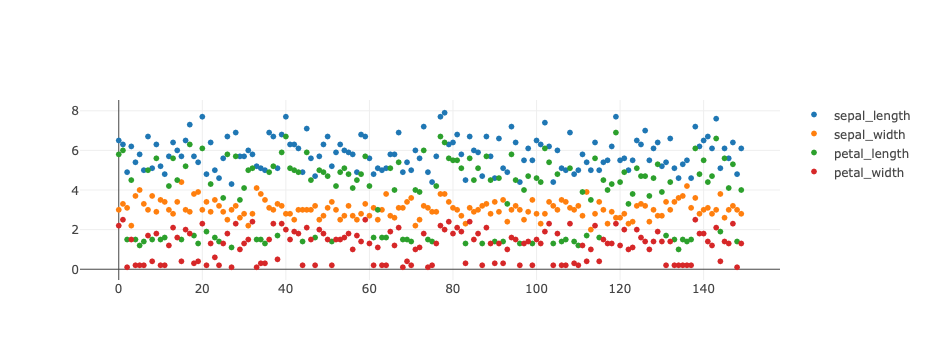

In [21]:
// Visualize data.
let x = Array::from_iter(0..target.len());

let mut plot = Plot::new();
for i in 0..features.ncols() {
  let y = features.slice(s![.., i]).to_owned(); 
  let t = Scatter::from_array(x.clone(), y).name(&feature_names[i]).mode(Mode::Markers);
  plot.add_trace(t);
}
plot

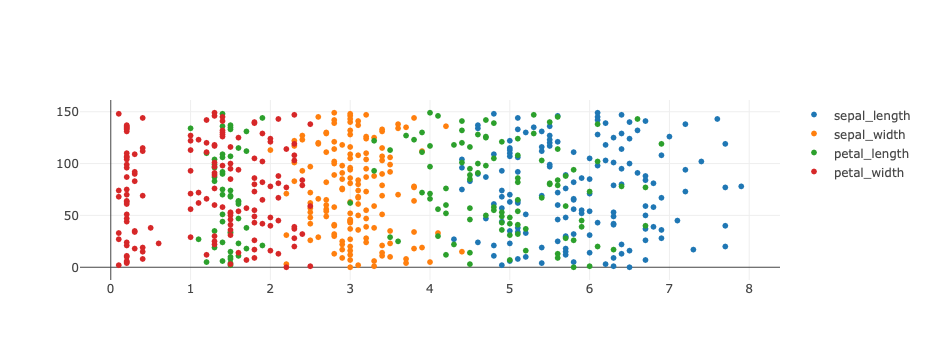

In [22]:
let x = Array::from_iter(0..features.nrows());

let mut plot = Plot::new();
for i in 0..features.ncols() {
  let y = features.slice(s![.., i]).to_owned();
  let t = Scatter::from_array(y, x.clone()).name(&feature_names[i]).mode(Mode::Markers);
  plot.add_trace(t);
}

plot

In [23]:
// use plotly::ndarray::ArrayTraces;

// let x = Array::from_iter(0..features.nrows());

// let traces = Scatter::default()
//   .mode(Mode::Markers)
//   .to_traces(x.clone(), features.clone(), ArrayTraces::OverColumns);

// let mut plot = Plot::new();
// plot.add_traces(traces);
// plot

## Convert `features` and `target` into `linfa::Dataset`

In [24]:
// Convert feature & label into a linfa Dataset object.
let dataset = Dataset::new(features, target)
  .with_feature_names(feature_names.to_owned())
  .map_targets(|t| match t{
    0 => "setosa",
    1 => "versicolor",
    2 => "virginica",
    _ => unreachable!(),
});

dataset

DatasetBase { records: [[6.5, 3.0, 5.8, 2.2],
 [6.3, 3.3, 6.0, 2.5],
 [4.9, 3.1, 1.5, 0.1],
 [6.2, 2.2, 4.5, 1.5],
 [5.4, 3.7, 1.5, 0.2],
 ...,
 [6.1, 2.6, 5.6, 1.4],
 [5.6, 3.0, 4.1, 1.3],
 [6.4, 3.2, 5.3, 2.3],
 [4.8, 3.0, 1.4, 0.1],
 [6.1, 2.8, 4.0, 1.3]], shape=[150, 4], strides=[4, 1], layout=Cc (0x5), const ndim=2, targets: ["virginica", "virginica", "setosa", "versicolor", "setosa", "setosa", "setosa", "versicolor", "setosa", "virginica", "setosa", "setosa", "versicolor", "virginica", "versicolor", "setosa", "virginica", "virginica", "setosa", "setosa", "virginica", "setosa", "versicolor", "setosa", "setosa", "versicolor", "virginica", "setosa", "virginica", "versicolor", "versicolor", "virginica", "virginica", "setosa", "setosa", "setosa", "versicolor", "virginica", "setosa", "virginica", "virginica", "virginica", "virginica", "virginica", "setosa", "virginica", "versicolor", "setosa", "virginica", "virginica", "versicolor", "setosa", "versicolor", "versicolor", "versicolor", "

In [25]:
// Split into train & validation set.
let (train, valid) = dataset.split_with_ratio(0.9);

println!("{:?}\n", train);
println!("{:?}\n", valid);

DatasetBase { records: [[6.5, 3.0, 5.8, 2.2],
 [6.3, 3.3, 6.0, 2.5],
 [4.9, 3.1, 1.5, 0.1],
 [6.2, 2.2, 4.5, 1.5],
 [5.4, 3.7, 1.5, 0.2],
 ...,
 [5.2, 2.7, 3.9, 1.4],
 [5.4, 3.4, 1.7, 0.2],
 [6.6, 3.0, 4.4, 1.4],
 [5.1, 3.4, 1.5, 0.2],
 [4.6, 3.6, 1.0, 0.2]], shape=[135, 4], strides=[4, 1], layout=Cc (0x5), const ndim=2, targets: ["virginica", "virginica", "setosa", "versicolor", "setosa", "setosa", "setosa", "versicolor", "setosa", "virginica", "setosa", "setosa", "versicolor", "virginica", "versicolor", "setosa", "virginica", "virginica", "setosa", "setosa", "virginica", "setosa", "versicolor", "setosa", "setosa", "versicolor", "virginica", "setosa", "virginica", "versicolor", "versicolor", "virginica", "virginica", "setosa", "setosa", "setosa", "versicolor", "virginica", "setosa", "virginica", "virginica", "virginica", "virginica", "virginica", "setosa", "virginica", "versicolor", "setosa", "virginica", "virginica", "versicolor", "setosa", "versicolor", "versicolor", "versicolor", "

### Build and Train a `DecisionTree` model

In [26]:
let model: DecisionTree<f64, &str> = DecisionTree::params()
  .split_quality(SplitQuality::Entropy)
  .fit(&train)?;

In [27]:
model

DecisionTree { root_node: TreeNode { feature_idx: 2, feature_name: "petal_length", split_value: 2.45, impurity_decrease: 0.9182959794998169, left_child: Some(TreeNode { feature_idx: 0, feature_name: "", split_value: 0.0, impurity_decrease: 0.0, left_child: None, right_child: None, leaf_node: true, prediction: "setosa", depth: 1 }), right_child: Some(TreeNode { feature_idx: 3, feature_name: "petal_width", split_value: 1.75, impurity_decrease: 0.7022004127502441, left_child: Some(TreeNode { feature_idx: 3, feature_name: "petal_width", split_value: 1.45, impurity_decrease: 0.12717780470848083, left_child: Some(TreeNode { feature_idx: 0, feature_name: "", split_value: 0.0, impurity_decrease: 0.0, left_child: None, right_child: None, leaf_node: true, prediction: "versicolor", depth: 3 }), right_child: Some(TreeNode { feature_idx: 3, feature_name: "petal_width", split_value: 1.65, impurity_decrease: 0.03423810005187988, left_child: Some(TreeNode { feature_idx: 2, feature_name: "petal_length"

### Make predictions with validation set

In [28]:
// Prediction for validation set.
let pred = model.predict(&valid);
println!("Prediction: {:?}\n", pred.to_vec());
println!("Ground truth: {:?}\n", &valid.targets().to_vec());

Prediction: ["setosa", "setosa", "setosa", "virginica", "virginica", "virginica", "versicolor", "versicolor", "virginica", "setosa", "versicolor", "versicolor", "virginica", "setosa", "versicolor"]

Ground truth: ["setosa", "setosa", "setosa", "virginica", "virginica", "virginica", "versicolor", "versicolor", "virginica", "setosa", "virginica", "versicolor", "virginica", "setosa", "versicolor"]



In [29]:
// Confusion matrix
let cm = pred.confusion_matrix(&valid)?;
cm

classes    | setosa     | virginica  | versicolor
setosa     | 5          | 0          | 0         
virginica  | 0          | 5          | 1         
versicolor | 0          | 0          | 4         


In [30]:
dbg!(&cm.f1_score());
dbg!(&cm.precision());
dbg!(&cm.recall());
dbg!(&cm.accuracy());

[src/lib.rs:224] &cm.f1_score() = 0.938856
[src/lib.rs:225] &cm.precision() = 0.93333334
[src/lib.rs:226] &cm.recall() = 0.9444444
[src/lib.rs:227] &cm.accuracy() = 0.93333334


### Make predictions with train set

In [31]:
// Prediction on train set.
let train_pred = model.predict(&train);
let train_cm = train_pred.confusion_matrix(&train)?;
train_cm

classes    | setosa     | virginica  | versicolor
setosa     | 45         | 0          | 0         
virginica  | 0          | 41         | 3         
versicolor | 0          | 2          | 44        


In [32]:
dbg!(&train_cm.accuracy());
dbg!(&train_cm.precision());
dbg!(&train_cm.recall());

[src/lib.rs:228] &train_cm.accuracy() = 0.962963
[src/lib.rs:229] &train_cm.precision() = 0.96321946
[src/lib.rs:230] &train_cm.recall() = 0.96278


In [33]:
// Export model to iris.tex file.

// File::create("../images/iris.tex")
//   .write_all(model.export_to_tikz().with_legend().to_string().as_bytes())?;